In [ ]:

import pyomo.environ as pyo
import pandas as pd
import numpy as np
import numpy.matlib

def opt(initList=[0,0,0,0,0,0,0,0,0],hour=0,soc0List=[0,0,0,0,0,0],flagConnCar=[1,1,1,1,1,1],spread=0.06):
    

    timeStamp=1/4 
    v2gEnabled=1
    storageEnabled=1
  
    percentageIncentive=1.1 # percentuale di incremento rispetto al soc di arrivo da usare come soc finale per incentivare il servizio
    error=1.2 # errore fisso inserito nei test tra il forecast e il profilo dato
    pvMultiplier=4 # moltiplicatore per la potenza del pv
    multiplierLoad=50 # moltiplicatore per la potenza del load

    #! profili a 15 minuti
    # power_consumption_profile_h24=np.array([25264.0, 25264.275, 25264.55, 25264.824999999997, 25265.1, 25304.824999999997, 25344.55, 25384.275, 25424.0, 26443.8625, 27463.725, 28483.5875, 29503.45, 28407.9, 27312.35, 26216.8, 25121.25, 30157.2125, 35193.175, 40229.1375, 45265.1, 48003.45, 50741.8, 53480.15, 56218.5, 52234.1625, 48249.825000000004, 44265.4875, 40281.15, 54592.4625, 68903.775, 83215.0875, 97526.4, 92884.6875, 88242.975, 83601.2625, 78959.55, 77751.375, 76543.20000000001, 75335.02500000001, 74126.85, 72432.71250000001, 70738.57500000001, 69044.4375, 67350.3, 69420.4875, 71490.675, 73560.8625, 75631.05, 68879.1375, 62127.225000000006, 55375.3125, 48623.4, 42009.1875, 35394.975, 28780.7625, 22166.55, 20339.2, 18511.85, 16684.5, 14857.15, 13526.3625, 12195.575, 10864.7875, 9534.0, 10368.225, 11202.45, 12036.675, 12870.9, 12931.824999999999, 12992.75, 13053.675, 13114.6, 15526.2125, 17937.825, 20349.4375, 22761.05, 23237.75, 23714.449999999997, 24191.149999999998, 24667.85, 25055.512499999997, 25443.175, 25830.8375, 26218.5, 26158.912500000002, 26099.325, 26039.737500000003, 25980.15, 25873.2, 25766.25, 25659.3, 25552.35, 25552.35, 25552.35, 25552.35])/1000#ec 2022 ottobre
    power_consumption_profile_h24=(np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00728459817860527, 0.01456919635721054, 0.02185379453581581, 0.02913839271442108, 0.13557933451461643, 0.24202027631481177, 0.34846121811500713, 0.4549021599152025, 0.47957831371558757, 0.5042544675159726, 0.5289306213163577, 0.5536067751167427, 0.5874229008614161, 0.6212390266060894, 0.6550551523507628, 0.6888712780954364, 0.6831492619696791, 0.677427245843922, 0.6717052297181648, 0.6659832135924076, 0.6883383879095383, 0.7106935622266688, 0.7330487365437994, 0.75540391086093, 0.7446243031701234, 0.7338446954793167, 0.7230650877885101, 0.7122854800977034, 0.7462051414289844, 0.7801248027602656, 0.8140444640915467, 0.8479641254228277, 0.8084608552016842, 0.7689575849805407, 0.7294543147593971, 0.6899510445382536, 0.7674632834036902, 0.8449755222691268, 0.9224877611345633, 1.0, 0.9571026921942093, 0.9142053843884185, 0.8713080765826279, 0.8284107687768371, 0.8682955652023757, 0.9081803616279142, 0.9480651580534526, 0.9879499544789913, 0.9230009467152891, 0.8580519389515868, 0.7931029311878847, 0.7281539234241825, 0.7483291128047455, 0.7685043021853083, 0.7886794915658712, 0.8088546809464341, 0.69595839669692, 0.5830621124474059, 0.4701658281978918, 0.35726954394837773, 0.2679521579612833, 0.17863477197418887, 0.08931738598709445, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])*multiplierLoad+10)*0.9#cooling database americano
    
    #? dichiaro il vettore sulle 24 ore del profilo pv estivo con il passaggio di una nuvola nel primo pomeriggio
    power_pv_profile_h24=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    2.13730053191489,4.27460106382979,\
    6.41190159574468,8.54920212765957,136.71642287234,\
    264.883643617021,393.050864361702,521.218085106383,\
    1058.8125,1596.40691489362,2134.00132978723,\
    2671.59574468085,3768.33650265957,4865.0772606383,\
    5961.81801861702,7058.55877659574,8212.96924867021,\
    9367.37972074468,10521.7901928191,11676.2006648936,\
    12547.5262300532,13418.8517952128,14290.1773603723,\
    15161.5029255319,15737.8770279255,16314.2511303191,\
    16890.6252327128,17466.9993351064,17639.8487034574,\
    17812.6980718085,17985.5474401596,18158.3968085106,\
    15086.7284574468,12015.060106383,8943.39175531915, \
    5871.72340425532,5728.27446808511,5584.82553191489,\
    5441.37659574468,5297.92765957447,7203.68886303192,\
    9109.45006648936,11015.2112699468,12920.9724734043,\
    12107.8071143617,11294.6417553191,10481.4763962766,\
    9668.31103723404,8621.74737367021,7575.18371010638,\
    6528.62004654255,5482.05638297872,4513.99488031915,\
    3545.93337765957,2577.871875,1609.81037234043,\
    1293.43653590426,977.062699468085,660.688863031915,\
    344.315026595745,258.236269946808,172.157513297872,86.0787566489362,\
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])/1000*error*pvMultiplier#summer cloud
    
    # dichiaro il vettore dei prezzi per ogni time step
    cost_per_kwh_grid_in_profile_h24=(np.array([0.0568, 0.0568, 0.0568, 0.0568, 0.0553, 0.0553, 0.0553, 0.0553,0.0546, 0.0546, 0.0546, 0.0546, 0.0543, 0.0543, 0.0543, 0.0543, 0.0542, 0.0542, 0.0542, 0.0542, 0.0541, 0.0541, 0.0541, 0.0541, 0.0542, 0.0542, 0.0542, 0.0542, 0.0556, 0.0556, 0.0556, 0.0556, 0.0577, 0.0577, 0.0577, 0.0577, 0.067, 0.067, 0.067, 0.067, 0.0914, 0.0914, 0.0914, 0.0914, 0.0785, 0.0785, 0.0785, 0.0785, 0.0699, 0.0699, 0.0699, 0.0699, 0.0632, 0.0632, 0.0632, 0.0632, 0.0611, 0.0611, 0.0611, 0.0611, 0.059, 0.059, 0.059, 0.059, 0.0578, 0.0578, 0.0578, 0.0578, 0.0576, 0.0576, 0.0576, 0.0576, 0.0577, 0.0577, 0.0577, 0.0577, 0.0618, 0.0618, 0.0618, 0.0618, 0.0609, 0.0609, 0.0609, 0.0609, 0.0602, 0.0602, 0.0602, 0.0602, 0.0599, 0.0599, 0.0599, 0.0599, 0.0576, 0.0576, 0.0576, 0.0576])+spread)*timeStamp


    # dichiaro il profilo dei prezzi della componente energia
    cost_per_kwh_grid_out_profile_h24=np.array([0.0568, 0.0568, 0.0568, 0.0568, 0.0553, 0.0553, 0.0553, 0.0553,0.0546, 0.0546, 0.0546, 0.0546, 0.0543, 0.0543, 0.0543, 0.0543, 0.0542, 0.0542, 0.0542, 0.0542, 0.0541, 0.0541, 0.0541, 0.0541, 0.0542, 0.0542, 0.0542, 0.0542, 0.0556, 0.0556, 0.0556, 0.0556, 0.0577, 0.0577, 0.0577, 0.0577, 0.067, 0.067, 0.067, 0.067, 0.0914, 0.0914, 0.0914, 0.0914, 0.0785, 0.0785, 0.0785, 0.0785, 0.0699, 0.0699, 0.0699, 0.0699, 0.0632, 0.0632, 0.0632, 0.0632, 0.0611, 0.0611, 0.0611, 0.0611, 0.059, 0.059, 0.059, 0.059, 0.0578, 0.0578, 0.0578, 0.0578, 0.0576, 0.0576, 0.0576, 0.0576, 0.0577, 0.0577, 0.0577, 0.0577, 0.0618, 0.0618, 0.0618, 0.0618, 0.0609, 0.0609, 0.0609, 0.0609, 0.0602, 0.0602, 0.0602, 0.0602, 0.0599, 0.0599, 0.0599, 0.0599, 0.0576, 0.0576, 0.0576, 0.0576])*timeStamp

     # ad ogni iterazione devo considerare solo una porzione dei profili facendo "scorrere il tempo", scrivo così dei nuovi vettori da usare dopo con la porzione di quelli precedenti
    # questi vettori costituiscono di fatto il forecast
    power_consumption=power_consumption_profile_h24[hour:]
    power_pv=power_pv_profile_h24[hour:]
    cost_per_kwh_grid_in=cost_per_kwh_grid_in_profile_h24[hour:]
    cost_per_kwh_grid_out=cost_per_kwh_grid_out_profile_h24[hour:]

    # ad ogni iterazione i valori iniziali dei vettori (cioè i valori al tempo 0, posizione 0 dei vettori) devono essere sostituiti dalle misure fatte sul campo passandole alla funzione, in questo caso initList  è un vettore passato ad ogi iterazione alla funzione per inizializzare i valori
    
    power_consumption[0]=initList[0]
    power_pv[0]=initList[1]
    SOC_0_storage=initList[2]

   
    
    #Definire numero colonnine 
    nWB=6
    coeff_maggiorazione_perdite=1.052# definito per l'EC per la compensazione delle perdite per il ritiro dedicato
    # timestamp temporale definito in ore
   
    nSecDelayWb=5#in secondi
    deadTimeCars=(1/3600)*nSecDelayWb#in ore
    timeStampCars=timeStamp-deadTimeCars # considero la minore energia erogata come un tinme stamp più piccolo per erogare energia dalle auto dovuta al tempo di intervento delle WB
    #efficienze di carica e scarica della batteria complessivo di caricatore

    # dichiaro le efficienze dei caricabatterie
    etaG2V=0.95
    etaV2G=0.96
    etaChStorage=0.95
    etaDchStorage=0.96

    #Definire flag di verifica connessione sulla base dei quali impongo i constraints
    flag_connected_car= {f'flag_connected_car_{idx}':int(flagConnCar[idx]) for idx in range(nWB)}#  # conquesto emulo la connessione o disconnessione dei veicoli singolarmente mettendo a 0

  

    nTimeStamp=len(power_pv) # conta il numero di istanti temporali inseriti
    counter18PMposition=int(6*(1/timeStamp)) # conto ad ogni iterazione la posizione delle 18 per cui si era ipotizzato le macchine si distacchino

    #Impongo p max v2g e g2v per ogni veicolo, e viene settato a 0 se il flag è 0
    capacity_vehicles=np.array([40,50,80,40,50,80])*np.array(list(flag_connected_car.values()))# kWh capacità dei veicoli

    # definisco i soc per ogni veicolo
    SOC_0_vehicles=np.array(initList[3:])*np.array(list(flag_connected_car.values())) # soc iniziale per i 4 veicoli, verrà misurato ad ogni time step e aggiornato prima di rilanciarlo al time step successivo

  
    # creo i soc minimi per le auto alle distacco e lo saturo a 0.9 nel caso l'incentivo lo lo facesse aumentare oltre il 90% (tale percentuale è una scelta arbitraria)
    last_SOC_min=[(soc0*percentageIncentive) if (soc0*percentageIncentive)<0.9 else 0.9 for soc0 in soc0List]
   
    SOC_min_vehicles=[]# inizializzo la lista dei soc min
    #! la posizione del soc incrementato deve scorrere durante le iterazioni dello script così da trovarsi sempre alle 18 del pomeriggio, se lo lascio per ultimo sempre
    #! non verrà mai applicato
    # ci si crea in questo modo un vettore di più elementi (uno per ogni veicolo), ognuno composto a sua volta da un vettore contenente i SoC minimi dei veicoli nei vari timstamp dal momento considerato fino al termine delle 24h,
    #di prassi si tiene un SoC min pari 0,35 per tutti i timestamp, mentre si pone pari al SoC incrementato del 10% ripsetto a quello iniziale
    for i,itm in enumerate(last_SOC_min):# tt è una variabile d'appoggio temporanea
        tt=([[0.35*flag_connected_car[f'flag_connected_car_{i}']]*(len(power_pv)-1)]*nWB)[i]#crea una lista di 0.35 per ogni veicolo ognuna lunga quanto il numero dei time stamp -1
        # itm=0.35 # da imporre se si vuole terminare la giornata a soc diverso dal 0.35 precedente
        tt.insert(-counter18PMposition,itm)
        SOC_min_vehicles.append(tt)  
 
    # setto il massimo soc per i veicoli
    # Questa linea di codice crea una matrice bidimensionale SOC_max_vehicles che rappresenta i livelli massimi di carica 
    # (SOC) delle batterie dei veicoli elettrici per tutti i timestamp considerati, impostandoli tutti a un valore costante di 0.9.
    SOC_max_vehicles=[[0.9]*nTimeStamp]*nWB

    # set della potenza massima dei veicoli per i funzionamenti in v2g e g2v
    PdchMax_vehicles=np.array([60,50,50,40,50,30])*np.array(list(flag_connected_car.values()))*v2gEnabled# kW potenza scarica massima dei veicoli
    PchMax_vehicles=np.array([80,70,80,60,50,50])*np.array(list(flag_connected_car.values()))# kW potenza carica massima dei veicoli, la potenza di carica deve essere abbastanza alta da soddisfare i vincoli sul soc, altrimenti diventa infeasible
    #!###############################################################

    # dichiaro la massima potenza in e out dalla rete (uguale alla fornitura generalmente)
    pGridInMax = 200000 # kW
    pGridOutMax = 200000 # kW




    # Definisco il modello
    model=pyo.ConcreteModel()

    # Variables gridIn/Out
    model.pGridIn=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp (nTimeStamp) che rappresenta l'energia prelevata dalla rete.
    model.pGridOut=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals) #Definisce una variabile continua non negativa per ogni timestamp che rappresenta l'energia immessa nella rete.

    # Variables EV
    # Questa parte del codice definisce delle variabili di ottimizzazione aggiuntive per il modello Pyomo. 
    # In particolare, queste variabili rappresentano l'energia trasferita dalla rete ai veicoli elettrici 
    # (pG2V - Grid to Vehicle) per ciascun veicolo e per ciascun intervallo di tempo. Ogni variabile ha un limite 
    # massimo definito da PchMax_vehicles, che rappresenta la massima potenza di carica per ciascun veicolo.
    for id,itm in enumerate([f'pG2V_car{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,PchMax_vehicles[id])*flag))# lim max può essere definito come: PchMax_vehicles[id]

    for id,itm in enumerate([f'pV2G_car{idx}' for idx in range(nWB)]):
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals,bounds=(0,PdchMax_vehicles[id])))

    for itm in [f'SOC_car{idx}' for idx in range(nWB)]:
        model.add_component(itm,pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals))


    # Stationary storage
    model.SOC_storage=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals)
    model.pStorageDch=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals)
    model.pStorageCh=pyo.Var(range(nTimeStamp),within=pyo.NonNegativeReals)
    storageCapacity=40#kWh
    SOC_min_storage=[0.2]*(len(power_pv)-1)
    SOC_min_storage.insert(len(power_pv),0.85)
   
    
    SOC_max_storage=0.9
    model.flag_dch_storage=pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))
    model.flag_ch_storage=pyo.Var(range(nTimeStamp), within=pyo.Binary,bounds=(0,1))
    pMaxChStorage=40*storageEnabled
    pMaxdChStorage=40*storageEnabled 




    ################################# Define objective function #####################################################################
    def cost_function(model):
        cost_grid_in=sum([model.pGridIn[idx]*cost_per_kwh_grid_in[idx] for idx in range(nTimeStamp)])
        cost_grid_out=sum([model.pGridOut[idx]*cost_per_kwh_grid_out[idx]*coeff_maggiorazione_perdite for idx in range(nTimeStamp)])
        return cost_grid_in-cost_grid_out # costo totale per l'intera giornata

    model.obj=pyo.Objective(rule=cost_function, sense=pyo.minimize)

    ################################# Define equality constraints #####################################################################
    # Assicura che la somma delle potenze prelevate, immesse, generate e consumate sia bilanciata in ogni momento,
    #  garantendo che l'energia sia conservata secondo il principio di conservazione dell'energia.
    model.powerBalance = pyo.ConstraintList()
    for i in range(nTimeStamp):
        exprex=power_consumption[i]-model.pGridIn[i] + model.pGridOut[i]-power_pv[i]-model.pStorageDch[i]+model.pStorageCh[i]
        for itm in range(nWB):
            exprex+=model.__dict__[f'pG2V_car{itm}'][i]-model.__dict__[f'pV2G_car{itm}'][i]  #aggiungo al bilancio
            # anche le potenza prelevate e immesse da ogni veicolo elettrico
        model.powerBalance.add(expr=exprex==0)

    ################################# Define inequality constraints #####################################################################
          # constraint sul SOC minimo e massimo per ogni veicolo
                
    model.minSOCconstr = pyo.ConstraintList()
    model.maxSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.minSOCconstr.add(model.__dict__[f'SOC_car{itm}'][i]>=SOC_min_vehicles[itm][i]*capacity_vehicles[itm])


    for i in range(nTimeStamp):
        for itm in range(nWB):
            model.maxSOCconstr.add(model.__dict__[f'SOC_car{itm}'][i]<=SOC_max_vehicles[itm][i]*capacity_vehicles[itm])

    # calcolo del SOC ad ogni passo temporale
    def SOCcalc(model,i,itm):
        if i!=0:
            return model.__dict__[f'SOC_car{itm}'][i]==model.__dict__[f'SOC_car{itm}'][i-1]+(timeStampCars*(model.__dict__[f'pG2V_car{itm}'][i]*etaG2V-model.__dict__[f'pV2G_car{itm}'][i]/etaV2G))
        else:
            return  model.__dict__[f'SOC_car{itm}'][i]==SOC_0_vehicles[itm]*capacity_vehicles[itm]+(timeStampCars*(model.__dict__[f'pG2V_car{itm}'][i]*etaG2V-model.__dict__[f'pV2G_car{itm}'][i]/etaV2G))

    model.SOCcalc= pyo.ConstraintList()
    for i in range(nTimeStamp):
        for itm in range(nWB):
                model.SOCcalc.add(SOCcalc(model,i,itm))

    
    model.maxG2V= pyo.ConstraintList()
    model.maxV2G= pyo.ConstraintList()
    
# potenza=0 se prima delle 9 del mattino e dopo le 18 della sera (tutti i veicoli 
# si connettono alle 9 e staccano alle 18)
    if hour<int(9*(1/timeStamp)):
        for i in range(0,int(9*(1/timeStamp))-hour):
            for itm in range(nWB):
                model.maxG2V.add(model.__dict__[f'pG2V_car{itm}'][i]==0)
                model.maxV2G.add(model.__dict__[f'pV2G_car{itm}'][i]==0)

        for i in range(int(9*(1/timeStamp))-hour,int(18*(1/timeStamp))-hour):
            for itm in range(nWB):
                model.maxG2V.add(expr=model.__dict__[f'pG2V_car{itm}'][i]<=flag_connected_car[f'flag_connected_car_{itm}']*PchMax_vehicles[itm])
                model.maxV2G.add(expr=model.__dict__[f'pV2G_car{itm}'][i]<=flag_connected_car[f'flag_connected_car_{itm}']*PdchMax_vehicles[itm])
        for i in range(int(18*(1/timeStamp))-hour,len(power_pv)):
            for itm in range(nWB):
                model.maxG2V.add(model.__dict__[f'pG2V_car{itm}'][i]==0)
                model.maxV2G.add(model.__dict__[f'pV2G_car{itm}'][i]==0)
    
    
    elif (hour>=int(9*(1/timeStamp)))&(hour<int(18*(1/timeStamp))):
        for i in range(0,int(18*(1/timeStamp))-hour):
            for itm in range(nWB):
                model.maxG2V.add(expr=model.__dict__[f'pG2V_car{itm}'][i]<=flag_connected_car[f'flag_connected_car_{itm}']*PchMax_vehicles[itm])
                model.maxV2G.add(expr=model.__dict__[f'pV2G_car{itm}'][i]<=flag_connected_car[f'flag_connected_car_{itm}']*PdchMax_vehicles[itm])
        for i in range(int(18*(1/timeStamp))+1-hour,len(power_pv)):
            for itm in range(nWB):
                model.maxG2V.add(model.__dict__[f'pG2V_car{itm}'][i]==0)
                model.maxV2G.add(model.__dict__[f'pV2G_car{itm}'][i]==0)
    elif hour>=int(18*(1/timeStamp)):
        for i in range(0,len(power_pv)):
            for itm in range(nWB):
                model.maxG2V.add(model.__dict__[f'pG2V_car{itm}'][i]==0)
                model.maxV2G.add(model.__dict__[f'pV2G_car{itm}'][i]==0)

            
    ######################################### Constraint dello storage###############
    def storageSOCcalc(model,i):
        if i!=0:
            return model.SOC_storage[i]==model.SOC_storage[i-1]+(timeStamp*(model.pStorageCh[i]*etaChStorage-model.pStorageDch[i]/etaDchStorage))
        else:
            return  model.SOC_storage[i]==SOC_0_storage*storageCapacity+(timeStamp*(model.pStorageCh[i]*etaChStorage-model.pStorageDch[i]/etaDchStorage))

    model.minStorageSOCconstr = pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.minStorageSOCconstr.add(model.SOC_storage[i]>=SOC_min_storage[i]*storageCapacity)
        model.minStorageSOCconstr.add(model.SOC_storage[i]<=SOC_max_storage*storageCapacity)



    model.SOC_storage_calc = pyo.ConstraintList()
    for i in range(nTimeStamp):
            model.SOC_storage_calc.add(storageSOCcalc(model,i))

    model.binaryStorage= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.binaryStorage.add(expr=model.flag_ch_storage[i]+model.flag_dch_storage[i]<=1)

    model.maxStorage= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.maxStorage.add(expr=model.pStorageCh[i]<=model.flag_ch_storage[i]*pMaxChStorage)
        model.maxStorage.add(expr=model.pStorageDch[i]<=model.flag_dch_storage[i]*pMaxdChStorage)


    ######################################### Constraint della rete in e out ###############
    model.flag_dch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)
    model.flag_ch_grid=pyo.Var(range(nTimeStamp), within=pyo.Binary)

    model.binaryGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.binaryGrid.add(expr=model.flag_ch_grid[i]+model.flag_dch_grid[i]<=1) 
    #in questo modo si è fatto in modo di definire delle flag che fanno in modo che la grid_in e grid_out non siano
    #contemporaneamente pari 1 (quindi che si preleva e immetta potenza dalla rete contemporaneamente)
    model.maxGrid= pyo.ConstraintList()
    for i in range(nTimeStamp):
        model.maxGrid.add(expr=model.pGridIn[i]<=model.flag_ch_grid[i]*pGridInMax)
        model.maxGrid.add(expr=model.pGridOut[i]<=model.flag_dch_grid[i]*pGridOutMax)



    ########################################## SOLVER #################################
    # solver = pyo.SolverFactory('gurobi_direct')
    solver = pyo.SolverFactory('glpk')
    results = solver.solve(model)

    if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
        print("Optimal solution found")

        # Create a DataFrame for the resultes 
        results_data = []
        for h in range(nTimeStamp):
            results_data.append({
                "Time Step": h,
                'Power PV':power_pv[h],
                'P load':power_consumption[h],
                "pGridIn [kW]": model.pGridIn[h].value,
                "pGridOut [kW]": model.pGridOut[h].value,
                "pStorageDch [kW]":model.pStorageDch[h].value,
                "pStorageCh [kW]":model.pStorageCh[h].value,
                "SOC Storage [%]":(model.SOC_storage[h].value/storageCapacity)*100,
            })
            for itm in range(nWB):
                results_data[-1][f"pG2V_car{itm}"+' [kW]']=model.__dict__[f'pG2V_car{itm}'][h].value
                results_data[-1][f"pV2G_car{itm}"+' [kW]']=model.__dict__[f'pV2G_car{itm}'][h].value
                results_data[-1][f"SOC_car{itm}"+'%']=(model.__dict__[f'SOC_car{itm}'][h].value/capacity_vehicles[itm])*100

        results_df = pd.DataFrame(results_data)
    results_df=results_df.rename({"Time Step":'Time Step '+str(timeStamp)+'h'},axis=1).set_index(f'Time Step {str(timeStamp)}'+'h')
    results_df['Prices_grid_in [€/kWh]']=cost_per_kwh_grid_in
    results_df['Prices_grid_out [€/kWh]']=cost_per_kwh_grid_out
    results_df['Cost_grid_in [€]']=results_df.apply(lambda x: x['pGridIn [kW]']*x['Prices_grid_in [€/kWh]'],axis=1)
    results_df['Cost_grid_out [€]']=results_df.apply(lambda x: x['pGridOut [kW]']*x['Prices_grid_out [€/kWh]'],axis=1)
    results_df=results_df.round(2)

 
    results_data = []
    h=0
    results_data.append({

        "pGridIn [kW]": model.pGridIn[h].value,
        "pGridOut [kW]": model.pGridOut[h].value,
        "pStorageDch [kW]":model.pStorageDch[h].value,
        "pStorageCh [kW]":model.pStorageCh[h].value,

    })
    for itm in range(nWB):
        results_data[-1][f"pG2V_car{itm}"+' [kW]']=model.__dict__[f'pG2V_car{itm}'][h].value
        results_data[-1][f"pV2G_car{itm}"+' [kW]']=model.__dict__[f'pV2G_car{itm}'][h].value

  


    return list(results_data[0].values()) # ritorno il valore 0 dei risultati che corrisonde al primo time step cioè quello da impostare dal sistema

Timestamp 0: 1.3785 kWh
Timestamp 1: 1.3156 kWh
Timestamp 2: 1.2555 kWh
Timestamp 3: 1.1982 kWh
Timestamp 4: 1.1435 kWh
Timestamp 5: 1.0913 kWh
Timestamp 6: 1.0414 kWh
Timestamp 7: 0.9939 kWh
Timestamp 8: 0.9485 kWh
Timestamp 9: 0.9052 kWh
Timestamp 10: 0.8639 kWh
Timestamp 11: 0.8245 kWh
Timestamp 12: 0.7868 kWh
Timestamp 13: 0.7509 kWh
Timestamp 14: 0.7166 kWh
Timestamp 15: 0.6839 kWh
Timestamp 16: 0.6527 kWh
Timestamp 17: 0.6229 kWh
Timestamp 18: 0.5944 kWh
Timestamp 19: 0.5673 kWh
Timestamp 20: 0.5414 kWh
Timestamp 21: 0.5167 kWh
Timestamp 22: 0.4931 kWh
Timestamp 23: 0.4706 kWh
Timestamp 24: 0.4491 kWh
Timestamp 25: 0.4286 kWh
Timestamp 26: 0.4090 kWh
Timestamp 27: 0.3904 kWh
Timestamp 28: 0.3725 kWh
Timestamp 29: 0.3555 kWh
Timestamp 30: 0.3393 kWh
Timestamp 31: 0.3238 kWh
Timestamp 32: 0.3090 kWh
Timestamp 33: 0.2949 kWh
Timestamp 34: 0.2814 kWh
Timestamp 35: 0.2686 kWh
Timestamp 36: 0.2563 kWh
Timestamp 37: 0.2446 kWh
Timestamp 38: 0.2335 kWh
Timestamp 39: 0.2228 kWh
Timestamp 

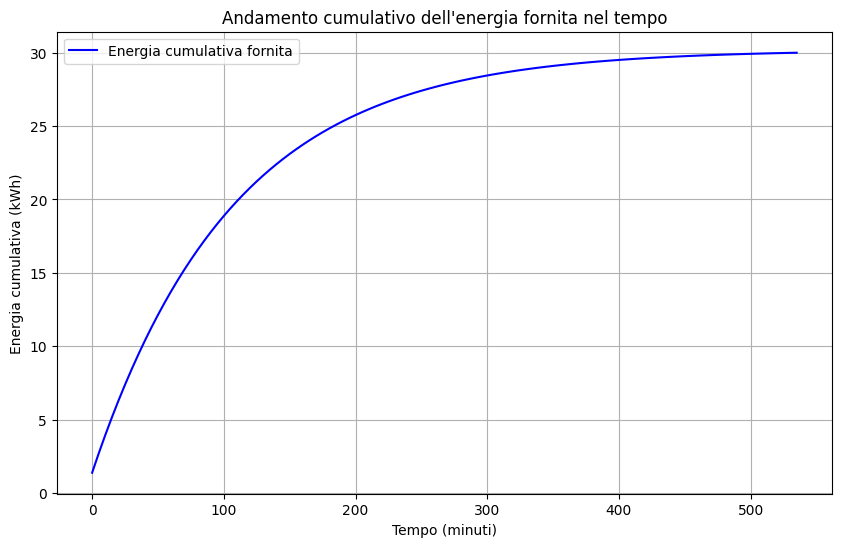

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri noti
capacity_battery = 50  # kWh, capacità della batteria del veicolo
initial_soc = 0.2      # Stato di carica iniziale (20%)
final_soc = 0.8        # Stato di carica finale (80%)
residence_time_hours = 9  # Tempo di residenza in ore (es: dalle 9:00 alle 18:00)
nTimeStamp = residence_time_hours * 12  # Numero di timestamp di 5 minuti in 9 ore

# Calcolo dell'energia totale necessaria in kWh
energy_needed = capacity_battery * (final_soc - initial_soc)

# Funzione esponenziale normalizzata
def exp_charge_schedule(total_energy, n_intervals):
    # Genera una sequenza esponenziale decrescente
    t = np.linspace(0, 1, n_intervals)
    exp_schedule = np.exp(-5 * t)  # Costante di decadimento regolabile
    exp_schedule /= exp_schedule.sum()  # Normalizzare in modo che la somma sia 1
    exp_schedule *= total_energy  # Scala alla quantità totale di energia necessaria
    return exp_schedule

# Calcolo dell'energia da fornire ad ogni timestamp
energy_schedule = exp_charge_schedule(energy_needed, nTimeStamp)

# Energia da fornire ad ogni timestamp (in kWh)
for i, energy in enumerate(energy_schedule):
    print(f'Timestamp {i}: {energy:.4f} kWh')

# Calcolo dell'energia cumulativa fornita nel tempo
cumulative_energy = np.cumsum(energy_schedule)

# Creazione del grafico
timestamps = np.arange(nTimeStamp) * 5  # Converti gli indici dei timestamp in minuti

plt.figure(figsize=(10, 6))
plt.plot(timestamps, cumulative_energy, label='Energia cumulativa fornita', color='b')
plt.xlabel('Tempo (minuti)')
plt.ylabel('Energia cumulativa (kWh)')
plt.title('Andamento cumulativo dell\'energia fornita nel tempo')
plt.grid(True)
plt.legend()
plt.show()
